## Environment

In [5]:
# install the modules
!pip install pennylane
!pip install aiohttp fsspec h5py
!pip install pennylane-lightning

# import quantum
import pennylane as qml
from pennylane import qchem
# import ML
import torch
import torch.nn as nn
import torch.optim as optim
# import data analysis
import numpy as np
import pandas as pd
# import draw
import matplotlib.pyplot as plt
# others
import time
import os
import logging
import random
from typing import List, Callable, Tuple
# silence!
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 僅顯示錯誤，忽略警告

In [31]:
from QKLSTM import QKLSTM

## Set Param.

In [6]:
# hyperparam
## LSTM
### opt for LSTM train: Adam
lr_lstm = 0.1
fixed_param_dim = 40
epochs = 5
steps_per_epoch = 5
max_steps_per_epoch = 15
min_steps_per_epoch = 5
max_mean_loss = 1e-2
min_mean_loss = 1e-3
conv_tol_lstm = 1e-5
loss_type = "weighted"
steps_recurrent_loop_for_test = 10 # for test

## VQE for test
lr_vqe = 0.1
mix_iter_vqe = 500
conv_tol_vqe = 1e-6
## optimizer for vqe test: Adam or SGD

## Dynamical LR if need
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.01,
#    decay_steps=100,
#    decay_rate=0.9,
#    staircase=True
#)

# param
## initial_method of params for traditional vqe: Zeros, Pi, Random
molecule = [
    ("H2", [0.5]),
    ("H2", [0.54]),
    ("H2", [0.58]),
    ("H2", [0.62]),
    ("H2", [0.66]),
    ("H2", [0.82]),
    ("H2", [0.86]),
    ("H2", [0.9]),
    ("H2", [0.94]),
    ("H2", [0.98]),
    ("H2", [1.02]),
    ("H2", [1.06]),
    ("H2", [1.1]),
    ("H2", [1.14]),
    ("H2", [1.18]),
    ("H2", [1.22]),
    ("H2", [1.26]),
    ("H2", [1.3]),
    ("H2", [1.34]),
    ("H2", [1.38]),
    ("H2", [1.42]),
    ("H2", [1.46]),
    ("H2", [1.5]),
    ("H2", [1.54]),
    ("H2", [1.58]),
    ("H2", [1.62]),
    ("H2", [1.66]),
    ("H2", [1.7]),
    ("H2", [1.74]),
    ("H2", [1.78]),
    ("H2", [1.82]),
    ("H2", [1.86]),
    ("H2", [1.9]),
    ("H2", [1.94]),
    ("H2", [1.98]),
    ("H2", [2.02]),
    ("H2", [2.06]),
    ("H2", [2.1]),
    ("H3+", [0.5]),
    ("H3+", [0.54]),
    ("H3+", [0.58]),
    ("H3+", [0.62]),
    ("H3+", [0.66]),
    ("H3+", [0.7]),
    ("H3+", [0.74]),
    ("H3+", [0.78]),
    ("H3+", [0.82]),
    ("H3+", [0.86]),
    ("H3+", [0.9]),
    ("H3+", [0.94]),
    ("H3+", [0.98]),
    ("H3+", [1.02]),
    ("H3+", [1.06]),
    ("H3+", [1.1]),
    ("H3+", [1.14]),
    ("H3+", [1.18]),
    ("H3+", [1.22]),
    ("H3+", [1.26]),
    ("H3+", [1.3]),
    ("H3+", [1.34]),
    ("H3+", [1.38]),
    ("H3+", [1.42]),
    ("H3+", [1.46]),
    ("H3+", [1.5]),
    ("H3+", [1.54]),
    ("H3+", [0.5]),
    ("H2", None),
    ("H3+", None),
    ("H4", None)

]

## Model

In [62]:
class DenseLayer(nn.Module):
    def __init__(self, in_features, out_features, use_bias=False, dtype=torch.float64):
        super(DenseLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=use_bias, dtype=dtype)

    def forward(self, x):
        return self.linear(x)

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(LSTMLayer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, x, hidden=None):
        if hidden is None:
            batch_size = x.size(0)
            h0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
            c0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
            hidden = (h0, c0)
        output, (hn, cn) = self.lstm(x, hidden)
        return output, hn, cn

In [63]:
class QLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, n_qubits=4, n_qlayers=1, backend="lightning.qubit"):
        super(QLSTM, self).__init__()
        self.qklstm = QKLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            n_qubits=n_qubits,
            n_qlayers=n_qlayers,
            batch_first=True,
            return_sequences=True,
            return_state=True,
            backend=backend,
            device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        )
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.device = self.qklstm.device

    def forward(self, x, hidden=None):
        if hidden is None:
            batch_size = x.size(0)
            h0 = torch.zeros(batch_size, self.hidden_size, dtype=torch.float64).to(self.device)
            c0 = torch.zeros(batch_size, self.hidden_size, dtype=torch.float64).to(self.device)
            hidden = (h0, c0)
        else:
            # Squeeze num_layers dimension for QKLSTM
            h, c = hidden
            h = h.squeeze(0).to(torch.float64)  # (num_layers, batch_size, hidden_size) -> (batch_size, hidden_size)
            c = c.squeeze(0).to(torch.float64)
            hidden = (h, c)

        # QKLSTM forward pass
        output, (hn, cn) = self.qklstm(x, init_states=hidden)

        # Ensure output is compatible with nn.LSTM: (batch_size, seq_length, hidden_size)
        if output.dim() == 2:
            output = output.unsqueeze(1)

        # Reshape hidden states to nn.LSTM format: (num_layers, batch_size, hidden_size)
        hn = hn.unsqueeze(0)
        cn = cn.unsqueeze(0)

        return output, hn, cn

In [57]:
def rnn_iteration_u(inputs, molecule_cost, rnn_layer, single_mapping, double_mapping):

    prev_cost, prev_params, prev_h, prev_c = inputs

    new_input = torch.cat([prev_cost, prev_params], dim=1)
    new_input = new_input.unsqueeze(1)

    outputs, new_h, new_c = rnn_layer(new_input, (prev_h, prev_c))
    new_params = outputs.squeeze(1)

    _cost = molecule_cost(new_params)
    new_cost = _cost.view(1, 1).float()

    return [new_cost, new_params, new_h, new_c]

def recurrent_loop_u(molecule_cost, steps=5, LossFunction="weighted", intermediate_steps=False, rnn_layer=None, single_mapping=None, double_mapping=None):
    initial_cost = torch.zeros((1, 1), dtype=torch.float64)
    initial_params = torch.zeros((1, fixed_param_dim), dtype=torch.float64)
    initial_h = torch.zeros((1, 1, fixed_param_dim), dtype=torch.float64)
    initial_c = torch.zeros((1, 1, fixed_param_dim), dtype=torch.float64)

    inputs = [initial_cost, initial_params, initial_h, initial_c]
    param_outputs = []
    cost_outputs = []

    for _ in range(steps):
        inputs = rnn_iteration_u(inputs, molecule_cost, rnn_layer, single_mapping, double_mapping)
        param_outputs.append(inputs[1])
        cost_outputs.append(inputs[0])

    loss = 0.0

    if LossFunction == "weighted":
        for t in range(len(cost_outputs)):
            coeff = 0.1 * (t + 1)
            loss += cost_outputs[t] * coeff
        loss = loss / len(cost_outputs)

    elif LossFunction == "descent":
        min_cost = cost_outputs[0]
        for t in range(1, len(cost_outputs)):
            min_cost_j = cost_outputs[t-1]
            for j in range(t):
                if cost_outputs[j] < min_cost_j:
                    min_cost_j = cost_outputs[j]
            loss += cost_outputs[t] - min_cost_j

    if intermediate_steps:
        return param_outputs + [loss]
    else:
        return loss

def train_step_u(molecule_cost, LossFunction="weighted", steps=10, rnn_layer=None, single_mapping=None, double_mapping=None, optimizer=None):
    optimizer.zero_grad()
    loss = recurrent_loop_u(molecule_cost, steps=steps, LossFunction=LossFunction, rnn_layer=rnn_layer, single_mapping=single_mapping, double_mapping=double_mapping)
    loss.backward()
    optimizer.step()
    return loss

In [69]:
def vqe_molecule_u(data, max_qubits):
    wires = range(max_qubits)
    orbitals = len(data.hf_state)
    electrons = sum(data.hf_state)
    single_wires, double_wires = qchem.excitations(electrons, orbitals)
    s_wires, d_wires = qml.qchem.excitations_to_wires(single_wires, double_wires)

    num_single = len(s_wires)
    num_double = len(d_wires)

    single_mapping = DenseLayer(fixed_param_dim // 2, num_single, use_bias=False).to(dtype=torch.float64)
    double_mapping = DenseLayer(fixed_param_dim // 2, num_double, use_bias=False).to(dtype=torch.float64)

    def circuit(params, wires):
        params = params.view(-1)
        half_dim = fixed_param_dim // 2
        single_input = params[:half_dim]
        double_input = params[half_dim:]

        single_params_full = single_mapping(single_input.unsqueeze(0)).squeeze(0)
        double_params_full = double_mapping(double_input.unsqueeze(0)).squeeze(0)

        single_params = single_params_full[:num_single]
        double_params = double_params_full[:num_double]

        mapped_params = torch.cat([single_params, double_params], dim=0)

        qml.UCCSD(mapped_params, range(orbitals), s_wires, d_wires, data.hf_state)

        return qml.expval(data.hamiltonian)

    def hamiltonian_cost(params, **kwargs):
        dev = qml.device("lightning.qubit", wires=wires)
        cost = qml.QNode(circuit, dev, diff_method="adjoint", interface="torch")
        return cost(params, wires=wires)

    return hamiltonian_cost

In [58]:
def vqe_optimization(molecule_cost, initial_params, max_iter=10, learning_rate=0.1, conv_tol=1e-6, optimizer="ADAM"):
    params = torch.tensor(initial_params, requires_grad=True, dtype=torch.float64)

    if optimizer == "ADAM":
        opt = optim.Adam([params], lr=learning_rate)
    elif optimizer == "SGD":
        opt = optim.SGD([params], lr=learning_rate)

    energy_history = [molecule_cost(params).item()]
    param_history = [params.detach().clone()]
    conv_iter = max_iter

    for iteration in range(max_iter):
        opt.zero_grad()
        cost = molecule_cost(params)
        cost.backward()
        opt.step()

        param_history.append(params.detach().clone())
        energy_history.append(cost.item())



        if iteration % 50 == 0:
            print(f"Step = {iteration+1}/{max_iter}, Energy= {energy_history[-1]:.8f} Ha")

        if iteration > 0 :
          conv = abs(energy_history[-1] - energy_history[-2])
          if conv <= conv_tol:
            conv_iter = iteration + 1
            break

    return conv_iter, param_history[-1], energy_history[-1], param_history, energy_history

## Data Loading and processing

In [11]:
def load_data(molecule, basis="STO-3G"):
  data_list = []

  for mol,bondlengths in molecule:
    # If bondlengths is None, load default bond length
    if bondlengths is None:
      data = qml.data.load("qchem", molname=mol, basis=basis)
      #print(f"{data[0].molecule},{data[0].bondlength}")

    else:
      # Otherwise, iterate over the bond lengths
      data = qml.data.load("qchem", molname=mol, basis=basis, bondlength=bondlengths)
      #print(f"{data[0].molecule},{data[0].bondlength}")

    for entry in data:
      data_list.append(entry)

  df = pd.DataFrame(data_list)
  return df

# Input molecule data
# HeH2 only has 6-31G, also, C2H6, CO2, N2H4, C2H4, N2H2, CH2O, C2H2 no data
# molecule = ["LiH", "Li2", "N2", "CO2", "BH3", "H2O2", "O2", "CO", "C2", "H4", "BeH2", "H3+", "NH3", "H2O",
            #"CH4", "HeH+", "H8", "H10", "NeH+", "OH-", "H6", "HF", "H2"]

In [12]:
def electrons_and_orbitals(hf_state):
  electrons = sum(hf_state)
  orbitals = int(len(hf_state))

  return electrons, orbitals

def max_params (dataset):
  max_s_wires = 0
  max_d_wires = 0

  for data in dataset:
    electrons, orbitals = electrons_and_orbitals(data.hf_state)

    single, double = qchem.excitations(electrons, orbitals)
    s_w, d_w = qml.qchem.excitations_to_wires(single, double)
    single = len(s_w)
    double = len(d_w)
    max_s_wires = max(max_s_wires, single)
    max_d_wires = max(max_d_wires, double)

  return max_s_wires, max_d_wires

## Download Data and then process

In [13]:
dataset = load_data(molecule, basis="STO-3G")
print(dataset.head())

                                                   0
0  <Dataset = molname: H2, basis: STO-3G, bondlen...
1  <Dataset = molname: H2, basis: STO-3G, bondlen...
2  <Dataset = molname: H2, basis: STO-3G, bondlen...
3  <Dataset = molname: H2, basis: STO-3G, bondlen...
4  <Dataset = molname: H2, basis: STO-3G, bondlen...


In [14]:
max_qubits = 0

for i in range(len(dataset[0])):
  if len(dataset[0][i].hf_state) > max_qubits:
    max_qubits = len(dataset[0][i].hf_state)

print(max_qubits)

8


In [15]:
dataset_list = list(dataset[0])
train_set = dataset_list[:68]
test_set = dataset_list[68]
print(f"train set: {train_set}")
print(f"test set: {test_set}")

train set: [<Dataset = molname: H2, basis: STO-3G, bondlength: 0.5, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.54, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.58, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.62, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.66, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.82, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.86, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.9, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.94, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.98, attributes: ['molname', 'basis', ...]>, <Dataset = molname: 

In [16]:
max_s_params, max_d_params = max_params(dataset[0])
print(f"the number of max single wires: {max_s_params}")
print(f"the number of max double wires: {max_d_params}")

the number of max single wires: 8
the number of max double wires: 18


## Train

In [72]:
max_s_params, max_d_params = max_params(dataset[0])
fixed_param_dim = fixed_param_dim
single_mapping = DenseLayer(fixed_param_dim // 2, max_s_params, use_bias=False, dtype=torch.float64)
double_mapping = DenseLayer(fixed_param_dim // 2, max_d_params, use_bias=False, dtype=torch.float64)
#rnn_layer = LSTMLayer(fixed_param_dim + 1, fixed_param_dim, num_layer = 1)
rnn_layer = QLSTM(fixed_param_dim + 1, fixed_param_dim, num_layers=1, n_qubits=4, n_qlayers=1, backend="lightning.qubit")

In [73]:
molecule_cost_list_u = [vqe_molecule_u(m, max_qubits) for m in train_set]

opt_u = optim.Adam(list(rnn_layer.parameters()) + list(single_mapping.parameters()) + list(double_mapping.parameters()), lr=lr_lstm)

epochs_u = epochs
steps_per_epoch_u = steps_per_epoch
previous_mean_loss_u = None

for epoch in range(epochs_u):
    start_time = time.time()

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs_u}")

    epoch_loss_u = []
    for i, molecule_cost in enumerate(molecule_cost_list_u):
        loss = train_step_u(molecule_cost, LossFunction=loss_type, steps=steps_per_epoch_u, rnn_layer=rnn_layer, single_mapping=single_mapping, double_mapping=double_mapping, optimizer=opt_u)
        epoch_loss_u.append(loss.item())

        if i % 10 == 0:
            print(f" > Molecule {i+1}/{len(molecule_cost_list_u)} - Loss: {loss.item():.8f}")
            print(f" > steps_per_epoch: {steps_per_epoch_u}")

    epoch_loss_u = np.array(epoch_loss_u)
    mean_loss_u = np.mean(epoch_loss_u)

    if epoch % 10 == 0:
        print(f" > Mean loss: {mean_loss_u:.6f}")

    if mean_loss_u > max_mean_loss:
        steps_per_epoch_u = min(steps_per_epoch_u + 2, max_steps_per_epoch)
    elif mean_loss_u < min_mean_loss:
        steps_per_epoch_u = max(steps_per_epoch_u - 2, min_steps_per_epoch)

    if previous_mean_loss_u is not None:
        rel_change = (previous_mean_loss_u - mean_loss_u) / (abs(previous_mean_loss_u))
        if rel_change <= conv_tol_lstm:
            print(f"Training Converged at Epoch {epoch+1}")
            break

    previous_mean_loss = mean_loss_u

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time of train for {epoch+1}: {execution_time:.1f} seconds")

Epoch 1/5
 > Molecule 1/68 - Loss: -0.31055301
 > steps_per_epoch: 5
 > Molecule 11/68 - Loss: -0.32303959
 > steps_per_epoch: 5
 > Molecule 21/68 - Loss: -0.28856143
 > steps_per_epoch: 5
 > Molecule 31/68 - Loss: -0.24235901
 > steps_per_epoch: 5
 > Molecule 41/68 - Loss: -0.20963092
 > steps_per_epoch: 5
 > Molecule 51/68 - Loss: -0.35508204
 > steps_per_epoch: 5
 > Molecule 61/68 - Loss: -0.33482680
 > steps_per_epoch: 5
 > Mean loss: -0.292241
Execution time of train for 1: 87.5 seconds
 > Molecule 1/68 - Loss: -0.29397357
 > steps_per_epoch: 5
 > Molecule 11/68 - Loss: -0.32004705
 > steps_per_epoch: 5
 > Molecule 21/68 - Loss: -0.28830391
 > steps_per_epoch: 5
 > Molecule 31/68 - Loss: -0.22498286
 > steps_per_epoch: 5
 > Molecule 41/68 - Loss: -0.20342612
 > steps_per_epoch: 5
 > Molecule 51/68 - Loss: -0.35993928
 > steps_per_epoch: 5
 > Molecule 61/68 - Loss: -0.33511358
 > steps_per_epoch: 5
Execution time of train for 2: 86.5 seconds
 > Molecule 1/68 - Loss: -0.28355667
 > 

## Test

In [74]:
# Save the model
torch.save(rnn_layer.state_dict(), "qlstm_vqe1.pth")

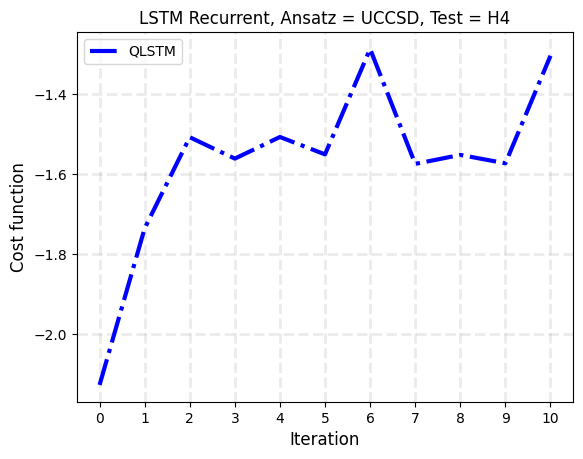

In [75]:
test_molecule_cost_u = vqe_molecule_u(test_set, max_qubits)

res = recurrent_loop_u(
    test_molecule_cost_u,
    steps=steps_recurrent_loop_for_test,
    LossFunction=loss_type,
    intermediate_steps=True,
    rnn_layer=rnn_layer,
    single_mapping=single_mapping,
    double_mapping=double_mapping
)

start_zeros = torch.zeros(fixed_param_dim, dtype=torch.float64)
guesses = [start_zeros] + [
    torch.reshape(r, (1, fixed_param_dim)) for r in res[:-1]
]

# Extract final loss
final_loss = res[-1]

# Compute LSTM losses
lstm_losses_u = [
    test_molecule_cost_u(torch.reshape(guess, (1, fixed_param_dim))).item()
    for guess in guesses
]

# Plot results
fig, ax = plt.subplots()

plt.plot(lstm_losses_u, color="blue", lw=3, ls="-.", label="QLSTM")
plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.title("LSTM Recurrent, Ansatz = UCCSD, Test = H4")
plt.legend()
ax.set_xticks(range(0, len(lstm_losses_u)))
plt.show()

In [76]:
conv_iter_u_adam, lstm_optimized_params_u_adam, lstm_optimized_energy_u_adam, lstm_param_history_u_adam, lstm_energy_history_u_adam = vqe_optimization(
    test_molecule_cost_u,
    initial_params=guesses[-1],
    max_iter=mix_iter_vqe,
    learning_rate=lr_vqe,
    conv_tol = conv_tol_vqe,
    optimizer = "ADAM"
)

<ipython-input-58-894259404>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(initial_params, requires_grad=True, dtype=torch.float64)


Step = 1/500, Energy= -1.30390632 Ha
Step = 51/500, Energy= -2.17718792 Ha
Step = 101/500, Energy= -2.18027711 Ha


In [80]:
lstm_energy_history_u_adam

[-1.3039063215255737,
 -1.3039063215255737,
 -1.4997944831848145,
 -1.6663562059402466,
 -1.802941083908081,
 -1.910820722579956,
 -1.9900188446044922,
 -2.04526948928833,
 -2.079911231994629,
 -2.0979676246643066,
 -2.1040704250335693,
 -2.1019513607025146,
 -2.095691442489624,
 -2.0896618366241455,
 -2.0867974758148193,
 -2.087846517562866,
 -2.0921261310577393,
 -2.0985682010650635,
 -2.1063928604125977,
 -2.1151821613311768,
 -2.1245391368865967,
 -2.1339571475982666,
 -2.143012046813965,
 -2.1514170169830322,
 -2.1588056087493896,
 -2.1646270751953125,
 -2.1683924198150635,
 -2.170011281967163,
 -2.169904947280884,
 -2.168774127960205,
 -2.167250156402588,
 -2.1658036708831787,
 -2.164851188659668,
 -2.1647284030914307,
 -2.165534734725952,
 -2.1670947074890137,
 -2.1690752506256104,
 -2.171142578125,
 -2.1730427742004395,
 -2.1745965480804443,
 -2.1756951808929443,
 -2.1763367652893066,
 -2.1766140460968018,
 -2.176652193069458,
 -2.1765763759613037,
 -2.17648983001709,
 -2.17643